In [85]:
import config
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from pprint import pprint
import pandas as pd 

In [26]:
auth = SpotifyClientCredentials(
    client_id=config.SPOTIPY_CLIENT_ID,
    client_secret=config.SPOTIPY_CLIENT_SECRET
)

token = auth.get_access_token()
sp = spotipy.Spotify(auth=token)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  


In [29]:
def get_tracks_from_playlist(playlist_URI):
    offset = 0
    tracklist = []
    while True:
        response = sp.playlist_tracks(playlist_URI,
                                     offset=offset,
                                     fields='items.track.id,total',
                                     additional_types=['track'])
        tracks = response['items']
        for track in tracks:
            track_id = track['track']['id']
            tracklist.append(track_id)

        offset = offset + len(response['items'])
#         print(offset, "/", response['total'])

        if len(response['items']) == 0:
            break
            
    return tracklist

def create_augmented_df(playlist_URI, polarity=None):
    df = pd.DataFrame(columns=['track id'])
    df['track id'] = get_tracks_from_playlist(playlist_URI)
    if polarity != None:
        df['gt label'] = df['track id'].apply(lambda x: polarity)
    df['track name'] = df['track id'].apply(lambda x: sp.tracks([x])['tracks'][0]['name'])
    df['artist'] = df['track id'].apply(lambda x: sp.tracks([x])['tracks'][0]['artists'][0]['name'])
    audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    df = df.reindex(df.columns.tolist() + audio_features, axis=1)
    for i in range(len(df)):
        track_id = df['track id'][i]
        analysis = sp.audio_features(track_id)[0]
        for feature in audio_features:
            df[feature][i] = analysis[feature]
    return df



In [30]:
# happy beats
df1 = create_augmented_df('spotify:playlist:37i9dQZF1DWSf2RDTDayIx', 1)
df1.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,track id,gt label,track name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,2u6Jm2klS4yvAlbSHlxUwI,1,Alane,Robin Schulz,0.581,0.799,3.0,-6.660,1.0,0.1640,0.04190,0.000009,0.1100,0.662,124.002
1,2hCKAnd2BPo2VD65XZC3rH,1,Your Place or Mine,Wahlstedt,0.863,0.608,7.0,-2.996,1.0,0.1490,0.18000,0.000003,0.1140,0.389,126.053
2,73h6Ma5QhBFrshEN2CTevS,1,Someday,Kygo,0.612,0.686,7.0,-6.838,1.0,0.1200,0.17300,0.000000,0.1410,0.326,122.115
3,75rGONmoi48LLYBFaGiYsv,1,Both Of Us - Edit,Jayda G,0.735,0.710,11.0,-10.222,1.0,0.0766,0.00851,0.762000,0.0684,0.507,123.962
4,5zn3TuX5oBHrEv8R9KyLir,1,Ladida (My Heart Goes Boom) [feat. ILIRA],CRISPIE,0.682,0.812,0.0,-4.931,1.0,0.0307,0.11100,0.000021,0.1370,0.455,126.040


In [31]:
# life sucks
df2 = create_augmented_df('spotify:playlist:37i9dQZF1DX3YSRoSdA634', 0)
df2.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,track id,track name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,4CxFN5zON70B3VOPBYbd6P,you were good to me,Jeremy Zucker,0.561,0.0848,2.0,-15.099,1.0,0.0404,0.913,0.000026,0.1120,0.206,102.128
1,0VhgEqMTNZwYL1ARDLLNCX,Can I Be Him,James Arthur,0.696,0.5430,11.0,-6.164,1.0,0.0489,0.308,0.000000,0.0939,0.479,107.969
2,4IhAzl3KH8P7KFJ5KfBnvy,Pearl in Sandbox,Júníus Meyvant,0.595,0.0626,8.0,-21.945,1.0,0.0452,0.917,0.076500,0.0987,0.259,126.337
3,2TIlqbIneP0ZY1O0EzYLlc,Someone You Loved,Lewis Capaldi,0.501,0.4050,1.0,-5.679,1.0,0.0319,0.751,0.000000,0.1050,0.446,109.891
4,6ynqpQIQ1kGtJILbxnCIQ8,Tourist,Axel Flóvent,0.455,0.2090,6.0,-12.150,0.0,0.0265,0.741,0.001940,0.1130,0.109,89.909


In [21]:
df_test = pd.concat([df1, df2])
df_test

,track id,gt label,track name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,2u6Jm2klS4yvAlbSHlxUwI,1.0,Alane,Robin Schulz,0.581,0.799,3,-6.660,1,0.1640,0.04190,0.000009,0.1100,0.662,124.002
1,2hCKAnd2BPo2VD65XZC3rH,1.0,Your Place or Mine,Wahlstedt,0.863,0.608,7,-2.996,1,0.1490,0.18000,0.000003,0.1140,0.389,126.053
2,73h6Ma5QhBFrshEN2CTevS,1.0,Someday,Kygo,0.612,0.686,7,-6.838,1,0.1200,0.17300,0.000000,0.1410,0.326,122.115
3,75rGONmoi48LLYBFaGiYsv,1.0,Both Of Us - Edit,Jayda G,0.735,0.710,11,-10.222,1,0.0766,0.00851,0.762000,0.0684,0.507,123.962
4,5zn3TuX5oBHrEv8R9KyLir,1.0,Ladida (My Heart Goes Boom) [feat. ILIRA],CRISPIE,0.682,0.812,0,-4.931,1,0.0307,0.11100,0.000021,0.1370,0.455,126.040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0xRO7EKgYKVB8zKIoiXMDD,NaN,God I Hope This Year Is Better Than The Last,SYML,0.353,0.185,0,-12.557,1,0.0388,0.92000,0.024400,0.1060,0.175,118.467
96,4pjNeKzXQcoYRdNDgdrwyR,NaN,Thursday - Acoustic,Jess Glynne,0.542,0.316,2,-6.189,1,0.0374,0.79500,0.000000,0.0960,0.580,140.869
97,5V0CRoCDeDpGTXZGWPTk3D,NaN,Silence,Reggii,0.741,0.117,7,-12.427,0,0.0490,0.93100,0.000164,0.1750,0.349,124.087
98,5cBjZGgtUcX5gjnrswWF6h,NaN,Golden Days - Live,Josh Savage,0.653,0.198,1,-10.538,1,0.0295,0.93300,0.000000,0.1200,0.286,100.168


In [22]:
df_test.to_csv('data/test.csv', index=False)

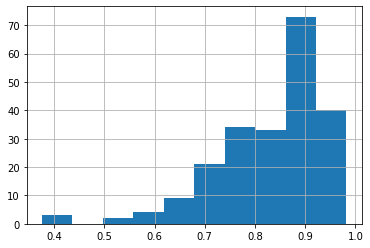

In [32]:
df1['energy'].hist()

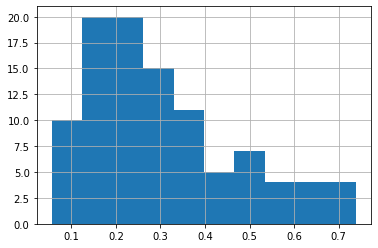

In [33]:
df2['energy'].hist()

In [34]:
train_df1 = create_augmented_df('spotify:playlist:37i9dQZF1DX7KNKjOK0o75') # have a great day
train_df2 = create_augmented_df('spotify:playlist:37i9dQZF1DX3rxVfibe1L0') # mood booster
train_df3 = create_augmented_df('spotify:playlist:37i9dQZF1DX4fpCWaHOned') # confidence boost
train_df4 = create_augmented_df('spotify:playlist:37i9dQZF1DX6xZZEgC9Ubl') # tear drop
train_df5 = create_augmented_df('spotify:playlist:37i9dQZF1DX59NCqCqJtoH') # idk.
train_df6 = create_augmented_df('spotify:playlist:37i9dQZF1DWSqBruwoIXkA') # down in the dumps
df_train = pd.concat([train_df1, train_df2, train_df3, train_df4, train_df5, train_df6])
df_train

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,track id,track name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,3fH4KjXFYMmljxrcGrbPj9,Don't You (Forget About Me),Simple Minds,0.660,0.816,2.0,-6.610,1.0,0.0299,0.1680,0.018100,0.0608,0.6780,111.346
1,4RvWPyQ5RL0ao9LPZeSouE,Everybody Wants To Rule The World,Tears For Fears,0.645,0.795,7.0,-12.095,1.0,0.0527,0.3470,0.003890,0.1040,0.5350,112.067
2,58E1XVmZTODC67YNjneuXM,Tainted Love,Soft Cell,0.542,0.450,7.0,-9.931,0.0,0.0361,0.5580,0.000006,0.5790,0.6260,144.437
3,2HuHopKnnuGQEpGb0CssCs,Hungry Like the Wolf,Duran Duran,0.654,0.903,0.0,-5.252,1.0,0.0798,0.0222,0.000000,0.2410,0.6070,129.442
4,1QbQL5m30YNvukitIqAnFG,Sunglasses At Night,Corey Hart,0.686,0.609,10.0,-11.469,0.0,0.0444,0.2580,0.000150,0.1130,0.7190,127.736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,4X2caEGywKxXKGImqNkBmt,If You're Gonna Lie,FLETCHER,0.671,0.763,8.0,-5.877,1.0,0.3050,0.6070,0.000022,0.4950,0.4690,149.870
88,0fNK8zD8S2douor2RMw6LW,Heart Hope,Oh Wonder,0.385,0.371,8.0,-13.365,1.0,0.0504,0.9410,0.044500,0.1080,0.0796,122.177
89,3rTnGUeDrnZV22DvRuUuXr,Wait,M83,0.437,0.229,2.0,-10.514,1.0,0.0308,0.2210,0.059900,0.0935,0.0754,147.911
90,6Vigp41BietH0WoFZ52JI5,All We Do,Oh Wonder,0.590,0.242,10.0,-11.724,0.0,0.0516,0.9780,0.000124,0.0906,0.3660,126.721


In [40]:
df_train.to_csv('data/train.csv', index=False)